## Jean-Eudes Rouffiac  

&nbsp;

&nbsp;

# <center> TP 1 : Introduction aux réseaux de neurones</center>

L'objectif de ce TP est triple : 
* mettre en oeuvre un MLP
* analyser l'influence des hyper-paramètres
* tester sur des problèmes de classification

# 1 Installation

&nbsp;



In [7]:
from tensorflow.keras.models import Sequential, model_from_yaml
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adam, Adamax, Nadam, Adadelta
import numpy as np


data = np.random.random((100, 2))
labels = np.random.randint(2, size=(100, 1))
model = Sequential()
model.add(Dense(32, input_shape=(2,)))
model.add(Activation("relu"))
model.add(Dense(units=1))
model.add(Activation("softmax"))
model.compile(optimizer="sgd", loss="binary_crossentropy")
model.fit(data, labels, epochs=5, batch_size=4)

Epoch 1/5
100/100 [==============================] - 1s 8ms/step - loss: 7.4929
Epoch 2/5
100/100 [==============================] - 0s 650us/step - loss: 7.4929
Epoch 3/5
100/100 [==============================] - 0s 637us/step - loss: 7.4929
Epoch 4/5
100/100 [==============================] - 0s 668us/step - loss: 7.4929
Epoch 5/5
100/100 [==============================] - 0s 775us/step - loss: 7.4929


# 1 Prise en main sur des données synthétiques 2D

&nbsp;

<p style="text-align:justify;"> Dans cette partie nous allons nous servir des données disponibles sur Moodle. *mixtureexampleTrain.csv* et *mixtureexampleTest.csv*. Le script suivant est aussi donné sur Moodle, il permet de récupérer le jeux de données d'entraînement et de test. Il contient aussi une fonction d'affichage. J'ai inversé les fichiers test et train car ils étaient inversés, il y avait plus de données test que d'entraînement. Finalement, pour des questions de temps lors des tests, nous gardons l'inversion des fichiers!</p>

&nbsp;

In [54]:
plt.close("all")
#%%
def plot_decision_2d(X, y, classifier, resolution=0.02, titre=' '):
    # setup marker generator and color map
    markers = ('s', 'v', 'o', '^', 'x')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0, X[:, 0].max() + 0
    x2_min, x2_max = X[:, 1].min() - 0, X[:, 1].max() + 0
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict_classes(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.figure()
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.45, c=cmap(idx),
                    marker=markers[idx], label= 'classe {}'.format(cl))
    plt.legend(loc='best')
    plt.title(titre, fontsize=12)
    
    plt.show()
    
# %% extraction des donnees
# apprentissage
datatrain = pd.read_csv("mixtureexampleTrain.csv", delimiter = "\t", header=None)
Ya = datatrain[2].values
Ya[Ya < 0] = 0
Xa = datatrain.drop(2, axis=1).values
print("\nDonnees apprentissage")
print("Labels: %d" % Ya.shape[0])
print("Lignes : %d, colonnes : %d" % (Xa.shape[0], Xa.shape[1]))

# test
datatest = pd.read_csv("mixtureexampleTest.csv", delimiter = "\t", header=None)
Yt = datatest[2].values
Yt[Yt < 0] = 0
Xt = datatest.drop(2, axis=1).values

print("\nDonnees test")
print("Labels: %d" % Yt.shape[0])
print("Lignes : %d, colonnes : %d" % (Xt.shape[0], Xt.shape[1]))


Donnees apprentissage
Labels: 1759
Lignes : 1759, colonnes : 2

Donnees test
Labels: 5272
Lignes : 5272, colonnes : 2


&nbsp;

<p style="text-align:justify;"> On crée un réseau de neurones à une couche cachée de taille nhu avec une fonction d'activation de type "relu". La couche de sortie est de taille 1 avec une fonction d'activation de type "sigmoid".</p>

&nbsp;

In [55]:
model = Sequential() # creation du RN vide
#ajout de la couche cachee
nhu = 64
model.add(Dense(units=nhu, input_shape=(2,)))
model.add(Activation("relu"))
# ajout de la couche de sortie
model.add(Dense(units=1))
model.add(Activation("sigmoid"))
# visualiser le nombre de parametres du model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                192       
_________________________________________________________________
activation_16 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
_________________________________________________________________
activation_17 (Activation)   (None, 1)                 0         
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


&nbsp;

<p style="text-align:justify;"> Le nombre de paramètres est alors de 257 qui correspond aux paramètres de la 1ere couche (64*(2+1)) additionné à la couche de sortie qui prend en entrée le nombre de neurones dans la couche cachée précédente + 1. On a donc 192 + 1 ce qui donne 257.</p>



&nbsp;

<p style="text-align:justify;">On compile maintenant le modèle en lui associant comme optimiseur le gradient stochastique, comme fonction coût l'entropie croisée et comme métrique d'évaluation du modèle le taux de bonne classification. On peut alors lancer l'apprentissage du modèle sur les données d'entraînement et visualiser la fonction de décision. On conservera l'historique de la loss et de l'accuracy et on affichera les courbes représentant l'accuracy et la loss en fonction du nombre d'epoch. </p>

&nbsp;

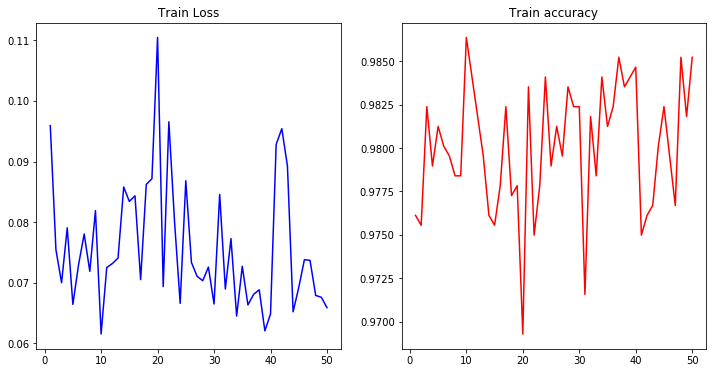

1759/1759 [==============================] - 1s 418us/step

Loss (App): 0.067
Taux classif (App): 0.985 

5272/5272 [==============================] - 0s 33us/step

Loss (test): 0.094
Taux classif (test): 0.978


In [67]:
# optimiseur gradient stochastique
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9)
# compilation du modele optimiseur, fonction de cout et metrique

def RNN(epoch, batch_size,optimizer):
    model.compile(optimizer=optimizer,loss="binary_crossentropy", metrics=["accuracy"])
    hist = model.fit(Xa, Ya, epochs=epoch, batch_size = batch_size,shuffle=True, verbose = 0)

    train_loss = hist.history["loss"]
    train_accuracy = hist.history["acc"]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_loss)+1), train_loss, color="blue")
    plt.title("Train Loss")
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracy)+1), train_accuracy, color="red")
    plt.title("Train accuracy")
    plt.show()
    
    score_app = model.evaluate(Xa, Ya)
    print("\nLoss (App): %.3f" % score_app[0])
    print("Taux classif (App): %.3f \n" % score_app[1])

    score_test = model.evaluate(Xt, Yt)
    print("\nLoss (test): %.3f" % score_test[0])
    print("Taux classif (test): %.3f" % score_test[1])
    
RNN(50, 32, sgd)

&nbsp;

<p style="text-align:justify;"> On oberve que lorque la loss diminue, l'accuracy augmente et vice versa. Ceci est logique car plus la loss est petite, meilleur est le modèle. Et meilleur est le modèle, meilleure est la classification.</p>
&nbsp;

<p style="text-align:justify;">On remarque que le taux de bonne classification est élevé. De plus le taux de bonne classification pour le jeu d'entraînement et de test sont semblables, ce qui indique qu'il n'y a pas eu de sous ou sur apprentissage.</p>


&nbsp;

<p style="text-align:justify;">Nous allons maintenant faire varier différents paramètres afin de voir l'impact sur les performances du modèle. Dans un premier temps nous nous intéressons au nombre d'epoch. Le nombre d'epoch est le nombre de fois ou le dataset en entier est passé dans le réseau de neurone. Nous le faisons alors varier afin de voir les performances sur le modèle.</p>

&nbsp;

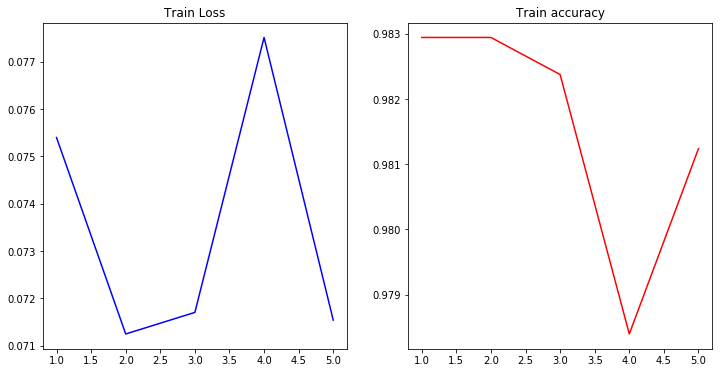

1759/1759 [==============================] - 1s 470us/step

Loss (App): 0.060
Taux classif (App): 0.982 

5272/5272 [==============================] - 0s 40us/step

Loss (test): 0.103
Taux classif (test): 0.975


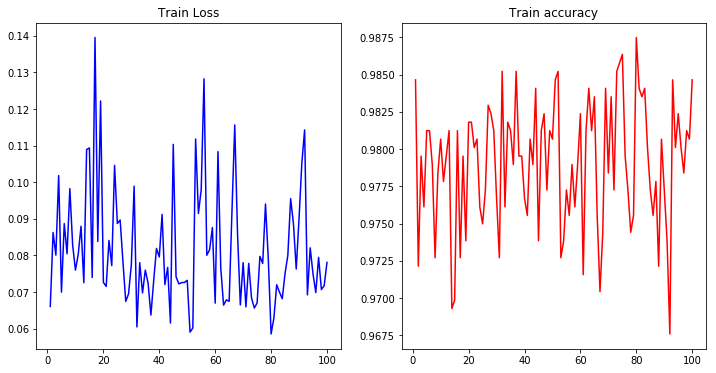

1759/1759 [==============================] - 1s 498us/step

Loss (App): 0.104
Taux classif (App): 0.972 

5272/5272 [==============================] - 0s 39us/step

Loss (test): 0.143
Taux classif (test): 0.964


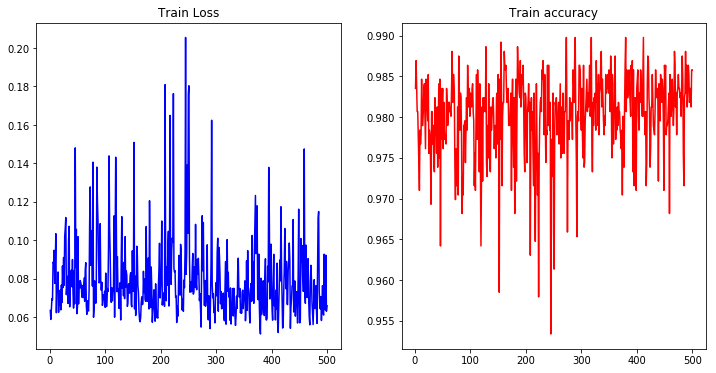

1759/1759 [==============================] - 1s 451us/step

Loss (App): 0.061
Taux classif (App): 0.985 

5272/5272 [==============================] - 0s 33us/step

Loss (test): 0.097
Taux classif (test): 0.979


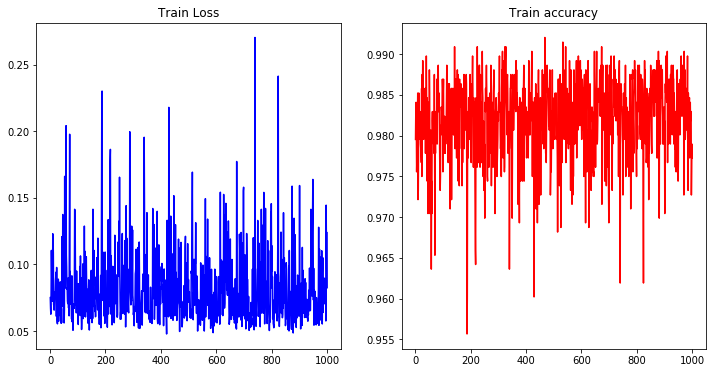

1759/1759 [==============================] - 1s 461us/step

Loss (App): 0.184
Taux classif (App): 0.961 

5272/5272 [==============================] - 0s 33us/step

Loss (test): 0.230
Taux classif (test): 0.954


In [69]:
nb_epoch = [5, 100, 500, 1000]
for epoch in nb_epoch:
    RNN(epoch, 32, sgd)


&nbsp;

<p style="text-align:justify;">On remarque que dans notre cas le nombre d'epoch n'influe pas sur la performance car pour 5 ou 500 epoch on obtient le même score. Ceci est sûrement du aux données qui sont trop facilement séparables car dans le cas de mon travail en entreprise, peu de nombre d'epoch entraîne un sous apprentisage et trop de nombre d'epoch entraîne un sur apprentissage. Pour certains modèles il est aussi nécessaire que le nombre d'epoch soit suivisant pour qu'il converge.</p>

&nbsp;

<p style="text-align:justify;">On s'intéresse maintenant au batch size. Le batch size est le nombre d'échantillon qui va passer par le réseau de neurones. Pour un batch_size de 32, l'algorithme va prendre les 32 premiers échantillons et les passer au réseau de neurones, puis les 32 suivantes et ainsi de suite. Une fois que tous les échantillons sont passés une fois, on a fait une epoch.</p>

&nbsp;

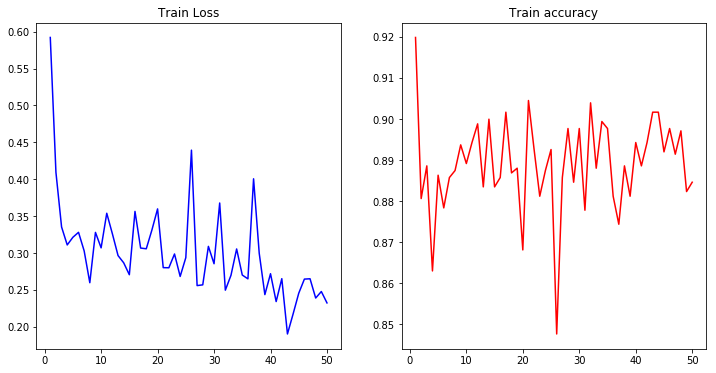

1759/1759 [==============================] - 1s 494us/step

Loss (App): 0.346
Taux classif (App): 0.897 

5272/5272 [==============================] - 0s 32us/step

Loss (test): 0.387
Taux classif (test): 0.894


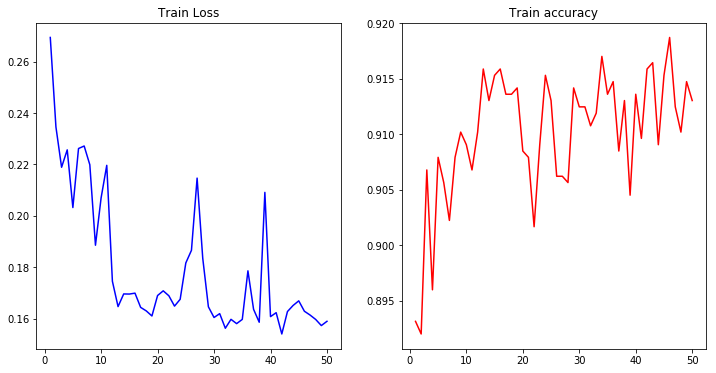

1759/1759 [==============================] - 1s 563us/step

Loss (App): 0.149
Taux classif (App): 0.917 

5272/5272 [==============================] - 0s 50us/step

Loss (test): 0.187
Taux classif (test): 0.913


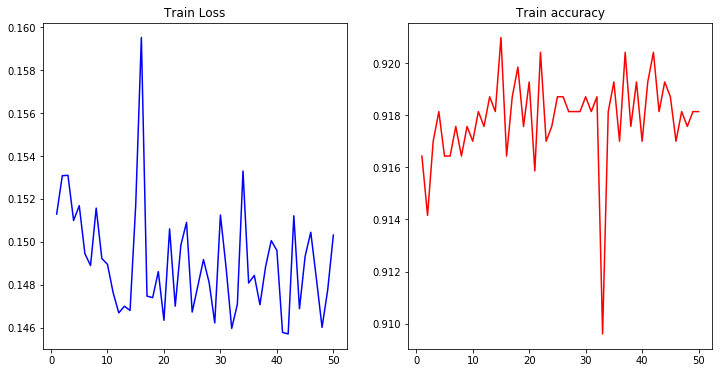

1759/1759 [==============================] - 1s 629us/step

Loss (App): 0.151
Taux classif (App): 0.915 

5272/5272 [==============================] - 0s 35us/step

Loss (test): 0.200
Taux classif (test): 0.916


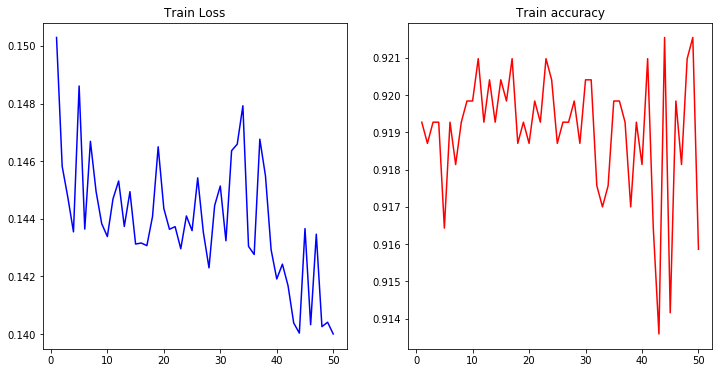

1759/1759 [==============================] - 1s 488us/step

Loss (App): 0.138
Taux classif (App): 0.921 

5272/5272 [==============================] - 0s 35us/step

Loss (test): 0.180
Taux classif (test): 0.922


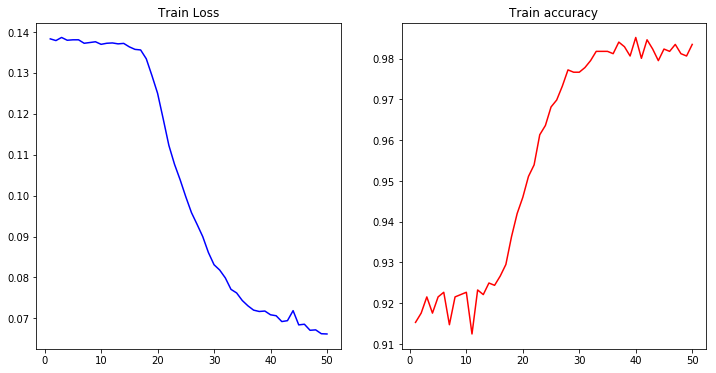

1759/1759 [==============================] - 1s 492us/step

Loss (App): 0.064
Taux classif (App): 0.984 

5272/5272 [==============================] - 0s 34us/step

Loss (test): 0.106
Taux classif (test): 0.976


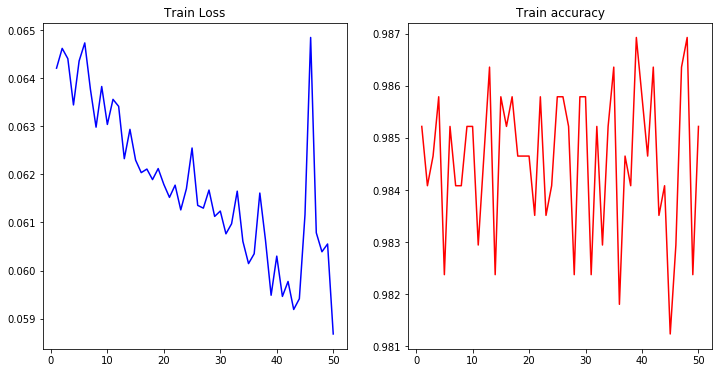

1759/1759 [==============================] - 1s 506us/step

Loss (App): 0.060
Taux classif (App): 0.986 

5272/5272 [==============================] - 0s 34us/step

Loss (test): 0.100
Taux classif (test): 0.979


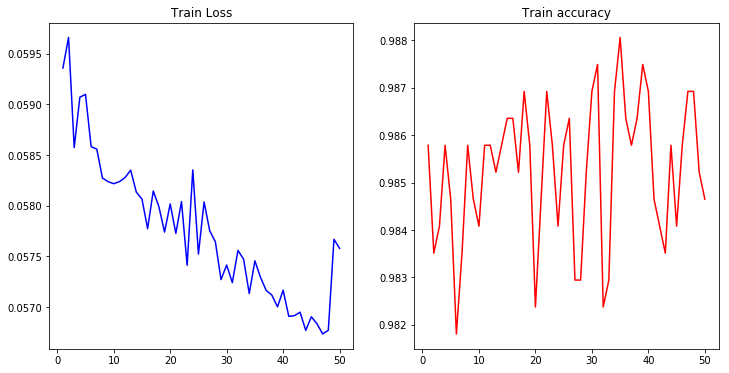

1759/1759 [==============================] - 1s 512us/step

Loss (App): 0.056
Taux classif (App): 0.987 

5272/5272 [==============================] - 0s 34us/step

Loss (test): 0.099
Taux classif (test): 0.978


In [70]:
nb_batch_size = [8, 16, 32, 64, 128, 256, 512]
for batch_size in nb_batch_size:
    RNN(50, batch_size, sgd)

&nbsp;

<p style="text-align:justify;">On peut voir que le batch_size influe sur la performance du modèle. Généralement, un batch_size très petit par rapport à la taille des données (par exemple un batch size de 2 pour 2000 données), entraînera des mauvaises performances notamment à cause des valeurs aberrantes. Un batch size trop important par rapport à la taille des données est dommage car on profite fait pas du fait que les poids du réseau de neurones peuvent être mis à jour plus souvent avec un batch size de taille moyenne. Aussi, un batch size plus petit que la taille des données rend l'entraînement du modèle plus rapide. Dans notre exemple, un batch size de 128 semble être efficace et suffisant.</p>


&nbsp;

<p style="text-align:justify;">Regardons maintenant l'impact de l'optimiseur, nous allons tester les optimiseurs trouvés sur la documentation de keras.</p>

&nbsp;

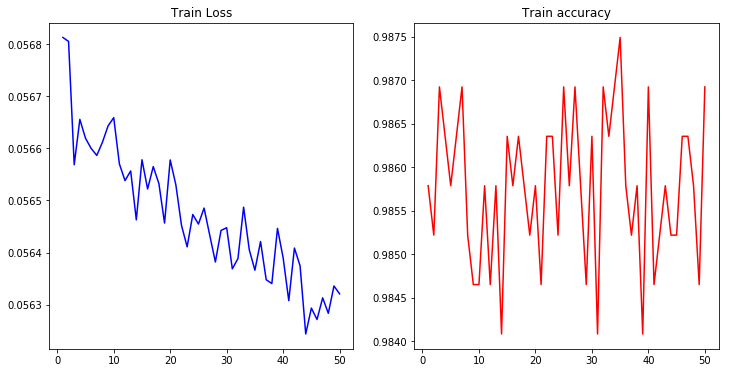

1759/1759 [==============================] - 1s 615us/step

Loss (App): 0.056
Taux classif (App): 0.986 

5272/5272 [==============================] - 0s 48us/step

Loss (test): 0.101
Taux classif (test): 0.978


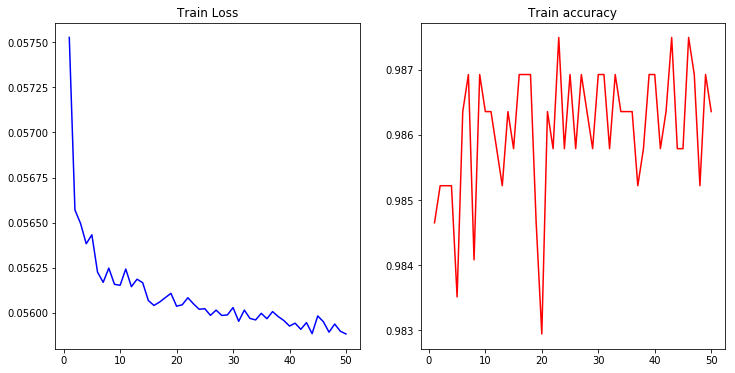

1759/1759 [==============================] - 1s 547us/step

Loss (App): 0.056
Taux classif (App): 0.987 

5272/5272 [==============================] - 0s 35us/step

Loss (test): 0.100
Taux classif (test): 0.979


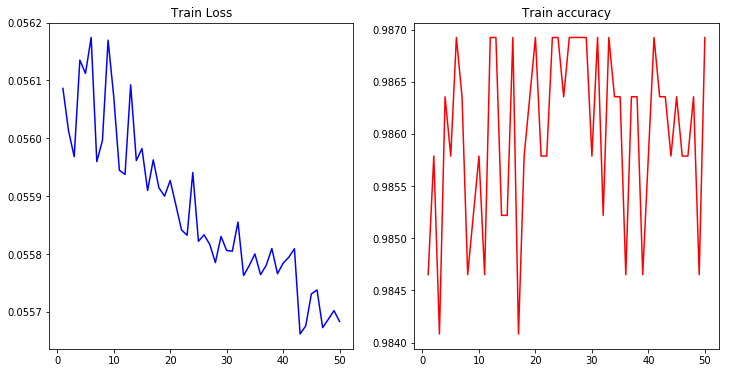

1759/1759 [==============================] - 1s 598us/step

Loss (App): 0.055
Taux classif (App): 0.987 

5272/5272 [==============================] - 0s 47us/step

Loss (test): 0.100
Taux classif (test): 0.980


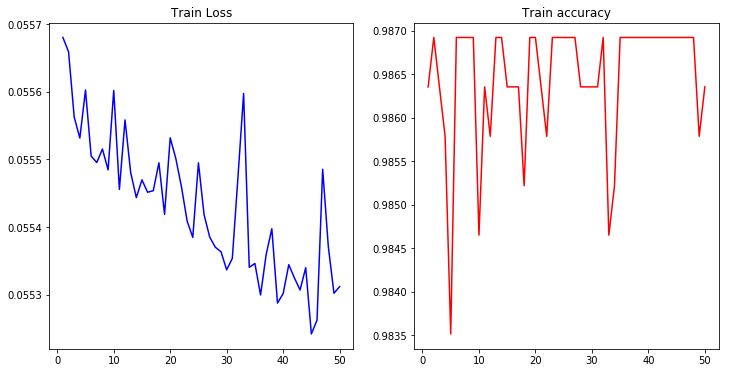

1759/1759 [==============================] - 1s 575us/step

Loss (App): 0.055
Taux classif (App): 0.986 

5272/5272 [==============================] - 0s 34us/step

Loss (test): 0.102
Taux classif (test): 0.980


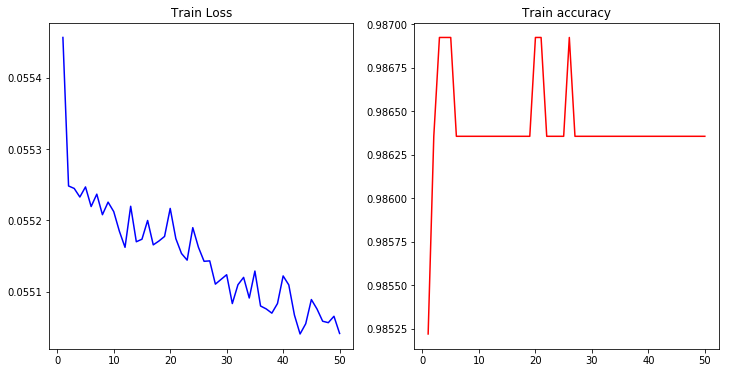

1759/1759 [==============================] - 1s 576us/step

Loss (App): 0.055
Taux classif (App): 0.986 

5272/5272 [==============================] - 0s 34us/step

Loss (test): 0.101
Taux classif (test): 0.980


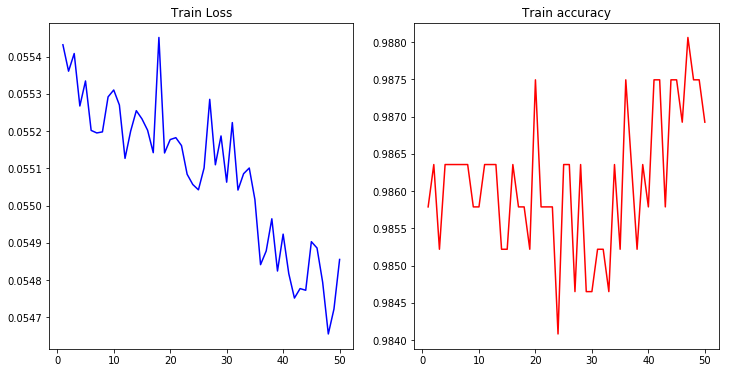

1759/1759 [==============================] - 1s 602us/step

Loss (App): 0.054
Taux classif (App): 0.988 

5272/5272 [==============================] - 0s 35us/step

Loss (test): 0.101
Taux classif (test): 0.979


In [71]:
# optimiseur gradient stochastique
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9)
rmsprop = RMSprop(rho=0.9)
adagrad = Adagrad()
adadelta = Adadelta(rho=0.95)
adam = Adam(beta_1=0.9, beta_2=0.999, amsgrad=False)
adamax = Adamax(beta_1=0.9, beta_2=0.999)
nadam = Nadam(beta_1=0.9, beta_2=0.999)

optimiseur = [rmsprop, adagrad, adadelta, adam, adamax, nadam]

for opti in optimiseur:
    RNN(50, 128, opti)

&nbsp;

<p style="text-align:justify;">On remarque qu'avec tous les optimiseurs, les résultats restent les mêmes. Encore une fois, ceci est sûrement dû au jeux de données qui est facilement séparable. Pour des jeux de données plus complexe, l'optimiseur influ sur les performances. Dans notre comparaison des optimiseurs, nous avons laissé les hyper paramètres comme le learning rate par défaut. Il aurait été intéressant de se pencher plus attentivement à comment sont construits les différents optimiseurs mais par manque de temps (TP à rendre à la fin de la séance), il n'est pas possible d'effectuer cela.</p>


&nbsp;

# 3 Réseaux de neurones denses pour MNIST



&nbsp;

<p style="text-align:justify;">L'objectif de cette partie est de reproduire la meilleure performance des RN denses sur les images MNIST. On reprend le script MLP-Mnist.py qui implémente le chargement et le pré-traitement des données.</p>


&nbsp;

11493376/11490434 [==============================] - 11s 1us/step

Donnees apprentissage
Nb de points : 60000
Lignes : 28, colonnes : 28

Donnees test
Nb de points : 10000
Lignes : 28, colonnes : 28


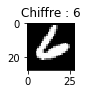

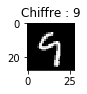

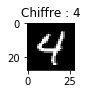

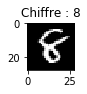

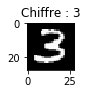

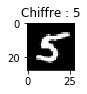

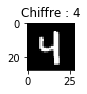

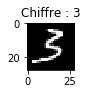

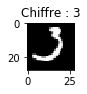

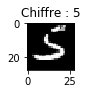

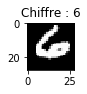

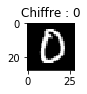

In [72]:


from __future__ import print_function
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, model_from_yaml
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD,  Adam

plt.close('all')



#%% Fonctions utiles
# Visualisation chiffre
def plot_digit(img, label=" "):
    img = img.reshape(28,28)
    plt.imshow(img, cmap=plt.get_cmap("gray"),  interpolation="nearest")
    plt.title("Chiffre : {}".format(label))
    plt.show()
    
#%% Chargement des donnees (MNIST est disponible dans la libraire Keras)
(Xa, Ya), (Xt, Yt) = mnist.load_data()
print("\nDonnees apprentissage")
print("Nb de points : %d" % Ya.shape[0])
print("Lignes : %d, colonnes : %d" % (Xa.shape[1], Xa.shape[2]))

print("\nDonnees test")
print("Nb de points : %d" % Yt.shape[0])
print("Lignes : %d, colonnes : %d" % (Xt.shape[1], Xt.shape[2]))
    
#%% Visualisation de quelques chiffres choisis aleatoirement
idx = np.random.permutation(Ya.shape[0])[0:12]
plt.figure(1)
for i in range(len(idx)):
    plt.subplot(4,3,i+1)
    plot_digit(Xa[idx[i]], Ya[idx[i]])
    
    
#%% Preparation des donnees : reshape en vecteur de taille 784
# flatten 28*28 images to a 784 vector for each image and conversion to float32 for normalization sake
nb_pixels = Xa.shape[1] * Xa.shape[2]
Xa = Xa.reshape(Xa.shape[0], nb_pixels).astype('float32')
Xt = Xt.reshape(Xt.shape[0], nb_pixels).astype('float32')

# normalize inputs from 0-255 to 0-1
Xa = Xa / 255
Xt = Xt / 255

# one-hot class encoding
nbclasses = len(np.unique(Ya))
Ya = to_categorical(Ya, nbclasses)
Yt = to_categorical(Yt, nbclasses)

&nbsp;

<p style="text-align:justify;">La dimension d'entrée correspond au nombre de pixel contenu dans les images qui est de 28x28 soit 784. On veut classer chaque image dans sa catégorie de chiffre correspondante, il y a donc 10 sorties. On remarquera que chaque valeur de pixel a été divisé par 255 afin d'avoir un nombre compris entre 0 et 1 (correspond à une normalisation des données). Le nombre d'images dans le jeu d'entraînement est de 60000 et de 10000 pour les données test.</p>


&nbsp;

<p style="text-align:justify;">On veut alors créer un réseau de neurones qui soit capable de classer chaque image dans sa classe correspondante. Pour ce faire, nous construisons un MLP avec une couche cachée de 800 neurones et une fonction d'activation "relu", suivie donc par la couche de sortie de taille 10 avec une fonction d'activation softmax. Le nombre de paramètre sera donc théoriquement de : (748 + 1 (biais)) * 800 + (800 + 1) * 10 = 636 010. </p>

In [73]:
model = Sequential() # creation du RN vide
#ajout de la couche cachee
nhu = 800
model.add(Dense(units=nhu, input_shape=(784,)))
model.add(Activation("relu"))
# ajout de la couche de sortie
model.add(Dense(units=10))
model.add(Activation("softmax"))
# visualiser le nombre de parametres du model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 800)               628000    
_________________________________________________________________
activation_18 (Activation)   (None, 800)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                8010      
_________________________________________________________________
activation_19 (Activation)   (None, 10)                0         
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
_________________________________________________________________


&nbsp;

<p style="text-align:justify;">On obtient alors le nombre de paramètres du modèle calculé précédemment! </p>

&nbsp;

<p style="text-align:justify;">On compile le modèle avec un loss "categorical_crossentropy" et comme métrique "accuracy". On prendra comme optimiseur Adam. </p>

In [86]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

&nbsp;

<p style="text-align:justify;">On peut alors apprendre le réseau ainsi configuré. On calculera le taux d’erreur sur le jeu de test et d'entraînement.</p>

&nbsp;



In [82]:
hist = model.fit(Xa, Ya, epochs=30, batch_size = 128 ,shuffle=True, verbose = 0)

score_app = model.evaluate(Xa, Ya)
print("\nLoss (App): %.3f" % score_app[0])
print("Taux classif (App): %.3f \n" % score_app[1])

score_test = model.evaluate(Xt, Yt)
print("\nLoss (test): %.3f" % score_test[0])
print("Taux classif (test): %.3f" % score_test[1])

60000/60000 [==============================] - 7s 117us/step

Loss (App): 0.008
Taux classif (App): 1.000 

10000/10000 [==============================] - 1s 96us/step

Loss (test): 0.181
Taux classif (test): 0.983


&nbsp;

<p style="text-align:justify;">En faisant passer le nombre d'epoch de 10 à 20, nous avons augmenter le score de classification en test de 97% à 98.3%. Malheureusement le temps de calcul pour 30 epochs est déjà très long et l'augmenter encore. 
Actuellement le meilleur score obtenu pour un réseau de neurone MLP est de 99.65% (voir article Cireşan, Meier, Gambardella and Schmidhuber (2010) (arXiv)).</p>

&nbsp;

<p style="text-align:justify;">Regardons maintenant si avec  le Stochastic gradient descent optimizer, le score est amélioré :</p>

&nbsp;

In [84]:
model2 = Sequential() # creation du RN vide
#ajout de la couche cachee
nhu = 800
model2.add(Dense(units=nhu, input_shape=(784,)))
model2.add(Activation("relu"))
# ajout de la couche de sortie
model2.add(Dense(units=10))
model2.add(Activation("softmax"))

sgd = SGD(lr=0.01)
model2.compile(optimizer=sgd,loss="categorical_crossentropy", metrics=["accuracy"])
hist = model2.fit(Xa, Ya, epochs=20, batch_size = 128 ,shuffle=True, verbose = 0)

score_app2 = model2.evaluate(Xa, Ya)
print("\nLoss (App): %.3f" % score_app2[0])
print("Taux classif (App): %.3f \n" % score_app2[1])

score_test2 = model2.evaluate(Xt, Yt)
print("\nLoss (test): %.3f" % score_test2[0])
print("Taux classif (test): %.3f" % score_test2[1])

60000/60000 [==============================] - 7s 113us/step

Loss (App): 0.008
Taux classif (App): 1.000 

10000/10000 [==============================] - 1s 96us/step

Loss (test): 0.201
Taux classif (test): 0.943


&nbsp;

<p style="text-align:justify;">On peut voir qu'avec l'optimiseur SGD, les performances du modèle sont considérablement réduites car on obtient que 94% de bonnes classifications en test. Ceci illustre bien l'importance du choix de l'optimiseur.</p>

&nbsp;

<p style="text-align:justify;">Testons maintenant les performances avec un réseau de neurones à 2 couches cachées. Nous prendrons comme taille de couches cachées 400 et 200.</p>

&nbsp;

In [87]:
model3 = Sequential() # creation du RN vide
#ajout de la couche cachee 1
model3.add(Dense(units=400, input_shape=(784,)))
model3.add(Activation("relu"))
#ajout de la couche cachee 2
model3.add(Dense(units=200, input_shape=(784,)))
model3.add(Activation("relu"))
# ajout de la couche de sortie
model3.add(Dense(units=10))
model3.add(Activation("softmax"))
# visualiser le nombre de parametres du model
model3.summary()

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model3.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

hist = model3.fit(Xa, Ya, epochs=30, batch_size = 128 ,shuffle=True, verbose = 0)

score_app3 = model.evaluate(Xa, Ya)
print("\nLoss (App): %.3f" % score_app3[0])
print("Taux classif (App): %.3f \n" % score_app3[1])

score_test3 = model.evaluate(Xt, Yt)
print("\nLoss (test): %.3f" % score_test3[0])
print("Taux classif (test): %.3f" % score_test3[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 400)               314000    
_________________________________________________________________
activation_27 (Activation)   (None, 400)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 200)               80200     
_________________________________________________________________
activation_28 (Activation)   (None, 200)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                2010      
_________________________________________________________________
activation_29 (Activation)   (None, 10)                0         
Total params: 396,210
Trainable params: 396,210
Non-trainable params: 0
_________________________________________________________________
6000

&nbsp;

<p style="text-align:justify;">On obtient alors un score de 98.3% ce qui est similaire au score précédent. Nous avons pris seulement 400 et 200 neurones pour les 2 couches cachées ce qui donne un nombre total de paramètres de 396 210, ce qui est largement inférieur à une couche cachée avec 800 neurones. Avec deux couches cachées composées d'encore plus de neurones, les performances pourraient encore s'améliorer mais le temps de calcul est trop long...</p>


&nbsp;

# 4 Pour aller plus loin

&nbsp;

<p style="text-align:justify;">Dans cette partie nous allons voir comment sauvegarder et charger un modèle déjà entraîné pour s'en servir pour classer de nouvelles valeurs. Nous verrons aussi comment stopper l'entraînement d'un réseau par exemple si la loss en validation n'augemente plus lors de 100 epochs par exemple.</p>


&nbsp;

<p style="text-align:justify;">La fonction suivante permet de sauvegarder le modèle une fois appris. Sauvegardons alors le model obtenu lors de l'entraînement de la base MNIST avec l'optimiseur Adam et une seule couche cachée.</p>


&nbsp;

In [90]:
from tensorflow.keras.models import Sequential, model_from_yaml

def saveModel(model, savename):
    # serialize model to YAML
    model_yaml = model.to_yaml()
    with open(savename+".yaml", "w") as yaml_file:
        yaml_file.write(model_yaml)
        print("Yaml Model ",savename+".yaml saved to disk")
        # serialize weights to HDF5
        model.save_weights(savename+".h5")
        print("Weights ",savename+".h5 saved to disk")
    
saveModel(model, "model_mnist_1hl_800")

Yaml Model  model_mnist_1hl_800.yaml saved to disk
Weights  model_mnist_1hl_800.h5 saved to disk


&nbsp;

<p style="text-align:justify;">On peut alors recharger le modèle. Testons la fonction donnée en chargeant le modèle puis en s'en servant pour prédire les données du jeu de test.</p>


&nbsp;

In [92]:
def loadModel(savename):
    yaml_file = open(savename+".yaml", "r")
    loaded_model_yaml = yaml_file.read()
    yaml_file.close()
    loaded_model = model_from_yaml(loaded_model_yaml)
    # load weights into new model
    loaded_model.load_weights(savename+".h5")
    print("Loaded model from disk")
    return loaded_model

model_load = loadModel("model_mnist_1hl_800")

Loaded model from disk


In [94]:
model_load.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
score_test = model_load.evaluate(Xt, Yt)
print("\nLoss (test): %.3f" % score_test[0])
print("Taux classif (test): %.3f" % score_test[1])

10000/10000 [==============================] - 2s 229us/step

Loss (test): 0.181
Taux classif (test): 0.983


&nbsp;

<p style="text-align:justify;">On obtient alors le même score obtenu que lors de la partie précédente avec le modèle. Le modèle a donc bien été chargé.</p>


&nbsp;

<p style="text-align:justify;">Regardons maintenant les possibilités qu'offre Keras dans le monitoring erreur de validation. On se servira des callbacks. Pour ce faire, introduisons un data set de validation. Le paramètre "validation_split" de keras dans model.fit permet de prendre en compte une proportion du dataset comme data set de validation. Reprenons alors notre model en ajoutant ce paramètre. On pourra alors visualiser les loss et la métrique sur les données d'apprentissage et de validation.</p>


&nbsp;

In [96]:
nbepochs = 20
hist = model.fit(Xa, Ya, validation_split=0.25, epochs=nbepochs,batch_size=64)

Train on 45000 samples, validate on 15000 samples
Epoch 1/20
45000/45000 [==============================] - 20s 444us/step - loss: 0.0050 - acc: 0.9997 - val_loss: 0.0190 - val_acc: 0.9981
Epoch 2/20
45000/45000 [==============================] - 20s 453us/step - loss: 0.0050 - acc: 0.9997 - val_loss: 0.0189 - val_acc: 0.9983
Epoch 3/20
45000/45000 [==============================] - 20s 441us/step - loss: 0.0050 - acc: 0.9997 - val_loss: 0.0189 - val_acc: 0.9983
Epoch 4/20
45000/45000 [==============================] - 20s 442us/step - loss: 0.0050 - acc: 0.9997 - val_loss: 0.0189 - val_acc: 0.9983
Epoch 5/20
45000/45000 [==============================] - 19s 432us/step - loss: 0.0050 - acc: 0.9997 - val_loss: 0.0189 - val_acc: 0.9982
Epoch 6/20
45000/45000 [==============================] - 20s 437us/step - loss: 0.0050 - acc: 0.9997 - val_loss: 0.0189 - val_acc: 0.9982
Epoch 7/20
45000/45000 [==============================] - 20s 447us/step - loss: 0.0050 - acc: 0.9997 - val_loss: 0.

(Text(0.5,0,'Epochs'),
 Text(0.5,1,'Accuracy'),
 <matplotlib.legend.Legend at 0xb47804400>)

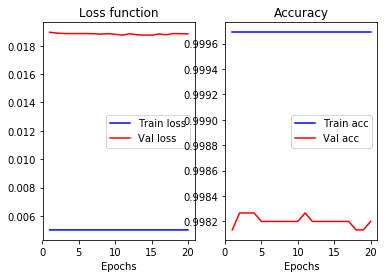

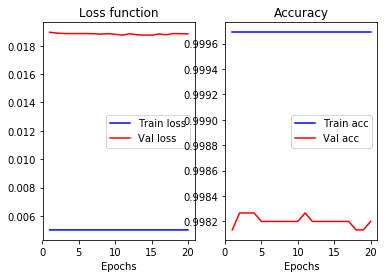

In [97]:
plt.figure(), plt.subplot(1,2,1)
plt.plot(range(1, nbepochs+1), hist.history["loss"], color="blue",label="Train loss")
plt.plot(range(1, nbepochs+1), hist.history["val_loss"], color="red", label="Val loss")
plt.xlabel("Epochs"), plt.title("Loss function"), plt.legend(loc="best")
plt.subplot(1,2,2)
plt.plot(range(1, nbepochs+1), hist.history["acc"], color="blue",label="Train acc")
plt.plot(range(1, nbepochs+1), hist.history["val_acc"], color="red",label="Val acc")
plt.xlabel("Epochs"), plt.title("Accuracy"), plt.legend(loc="best")
plt.show()

&nbsp;

<p style="text-align:justify;">(Seulement 20 epoch par manque de temps et ordinateur lent...).
On remarque que les performances sur les données de validation ne s'améliorent plus après un certain nombre d'epoch. L'apprentissage aurait donc plus s'arrêter plus être arrêté plus tôt. Avec Keras il est possible de réaliser l'arrêt prématuré du modèle. Il est aussi possible de sauvergarder le modèle après chaque epoch ou bien lorsque le modèle a amélioré la valeur de l'accuracy en validation par exemple. Cela se fait avec le code suivant :</p>


&nbsp;


In [102]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# monitor the validation accuray
early_stop = EarlyStopping(monitor="val_acc", min_delta=0.1, patience =2, verbose=0)
# min_delta : minimum change in the monitored quantity to qualify asan improvement
# patience : number of epochs with no improvement after which training will be stopped
# training of the model with early stopping
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [early_stop, checkpoint]
model.fit(Xa, Ya, validation_split=0.25, epochs=20, batch_size=64, callbacks = callbacks_list)

Train on 45000 samples, validate on 15000 samples
Epoch 1/20
45000/45000 [==============================] - 21s 468us/step - loss: 0.0050 - acc: 0.9997 - val_loss: 0.0189 - val_acc: 0.9982
Epoch 2/20
45000/45000 [==============================] - 19s 430us/step - loss: 0.0050 - acc: 0.9997 - val_loss: 0.0189 - val_acc: 0.9983
Epoch 3/20
45000/45000 [==============================] - 20s 435us/step - loss: 0.0050 - acc: 0.9997 - val_loss: 0.0189 - val_acc: 0.9983


&nbsp;

<p style="text-align:justify;">Le paramètre patience indique le critère d'arrêt de l'entraînement du modèle. Si le nombre d'epoch de la patience est atteint, cela s'arrête. Il faut aussi choisir un critère d'amélioration qui est le "min_delta". Ce paramètre indique le changement minimum de monitor entre deux epochs pour que cela soit qualifié comme amélioration du modèle. Pour la sauvegarde de modèle, on créé un nouveau callback grâce à ModelCheckpoint. On sauvegarde seulement le modèle lorsque val_accuracy augmente (mode = max). </p>


&nbsp;


<p style="text-align:justify;">On voit qu'ici l'entraînement s'est bien arrêté car vall_acc n'a pas augmenté de plus de 0.1 après 2 epoch. Deux modèles ont été sauvés sur mon ordinateur car il y a 2 améliorations de val_acc. </p>


In [8]:
model = Sequential()
model.add(Conv2D(6, [5,5], strides=(1, 1), padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
model.add(Conv2D(6, [5,5], strides=(1, 1), padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

ValueError: This model has never been called, thus its weights have not yet been created, so no summary can be displayed. Build the model first (e.g. by calling it on some data).